# Filamentation Plasma 1

In [13]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
from lens import design
import matplotlib.pyplot as plt
from ionization import adk
from scipy.interpolate import interp1d
from scipy.optimize import newton
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Filamentation/FP_1/'
lam = 0.8
tau = 70.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Filamentation plasma source with a spherical lens focused behind a gas jet. Initial parmas based off of UCLA laser parameters. Gas Jet profile is a guess.

In [2]:
def plot_laser_plasma(I, ne, ext, name=None):
    plt.figure(figsize=(16, 4), dpi=300)
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    if name is not None:
        plt.savefig(path+name+'.png')
    plt.show()

In [3]:
def ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z, plot=True):
    name = "Energy=%0.2fmJ_w0=%0.1fum_z0=%0.2fmm_n0=%0.2E_T=%0.0feV" % (energy*1e3, w0, z0*1e-3, n0, temp)
    z = np.linspace(-Z/2, Z/2, Nz)
    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 20,
        'cyl' : True,
        'tau' : tau,
        'z0' : -Z/2+z0,
        'name' : name+'_Beam',
        'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
        'waist' : w0
    }

    ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
    beam = laserbeam.GaussianLaser(pulseParams)
    if plot:
        beam.plot_current_intensity()
    beam.propagate(z-z[0], 1.0)
    e = np.zeros((Nz, Nx), dtype='complex128')
    for i in range(Nz):
        e[i, :] = beam.load_field(i+1)[0]
        
    a = 3.31743175609e+16 #cm-3
    b = 0.00049976694808  #um-1
    c = 2.39194210599e+14 #cm-3
    ## sig(y) = sa + sb y + sc y**2     From ApproxGasJet_SigVSAxial.py
    sa = 2986.91262632; sb = 0.550205150854; sc = -5.09030500347e-06

    xaxis = np.reshape(beam.x, (Nx, 1, 1))
    yaxis = np.reshape(beam.y, (1, Nx, 1))
    zaxis = np.reshape(z, (1, 1, Nz))

    y_expo = np.exp(-b*(yaxis))
    xz_gauss = np.exp(-(np.square(xaxis)+np.square(zaxis))/(2*np.square(sa+sb*yaxis+sc*np.square(yaxis))))
    n = n0 * y_expo * xz_gauss
    n_slice = np.zeros((Nz, Nx))
    n_slice = np.flip(np.transpose(n[:, int(Nx/2), :]), axis=0)

    ne = n_slice*adk.gaussian_frac(atom['EI'], abs(e), tau, atom['Z'], atom['l'])
    I = beam.intensity_from_field(e)
    if plot:
        plot_laser_plasma(I, ne, ext, name+'_beam')
    
    pulseParams['name'] = name + '_Pulse'
    plasmaParams = {
        'Nx' : Nx,
        'Ny' : Nx,
        'Nz' : Nz,
        'X' : X,
        'Y' : X,
        'Z' : Z,
        'atom' : atom,
        'path' : path,
        'load' : False,
        'cyl' : True,
        'name' : name+'_Plasma',
        'n0' : n0/1e17
    }
    pulse = laserpulse.GaussianPulse(pulseParams)
    print('Initial pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
    ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
    hydrogen = plasma.Plasma(plasmaParams)

    # Initialize gas density
    ne = np.zeros((Nx, Nx, Nz), dtype='double')
    hydrogen.initialize_plasma(n/1e17, ne)

    interactions.pulse_plasma_energy(pulse, hydrogen, temp)
    print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
    e = np.zeros((Nz, Nx), dtype='complex128')
    ne = np.zeros((Nz, Nx))
    for i in range(0, Nz-1):
        ne[i, :] = hydrogen.load_plasma_density(i)[0]
    for i in range(Nz):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = ionization.intensity_from_field(e)
    ne = ne*1e17
    plot_laser_plasma(I, ne, ext, name+'_pulse')
    return pulse

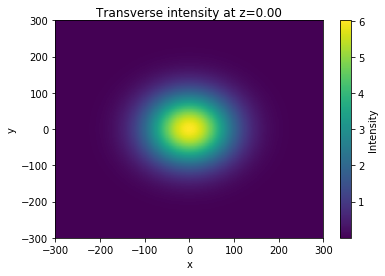

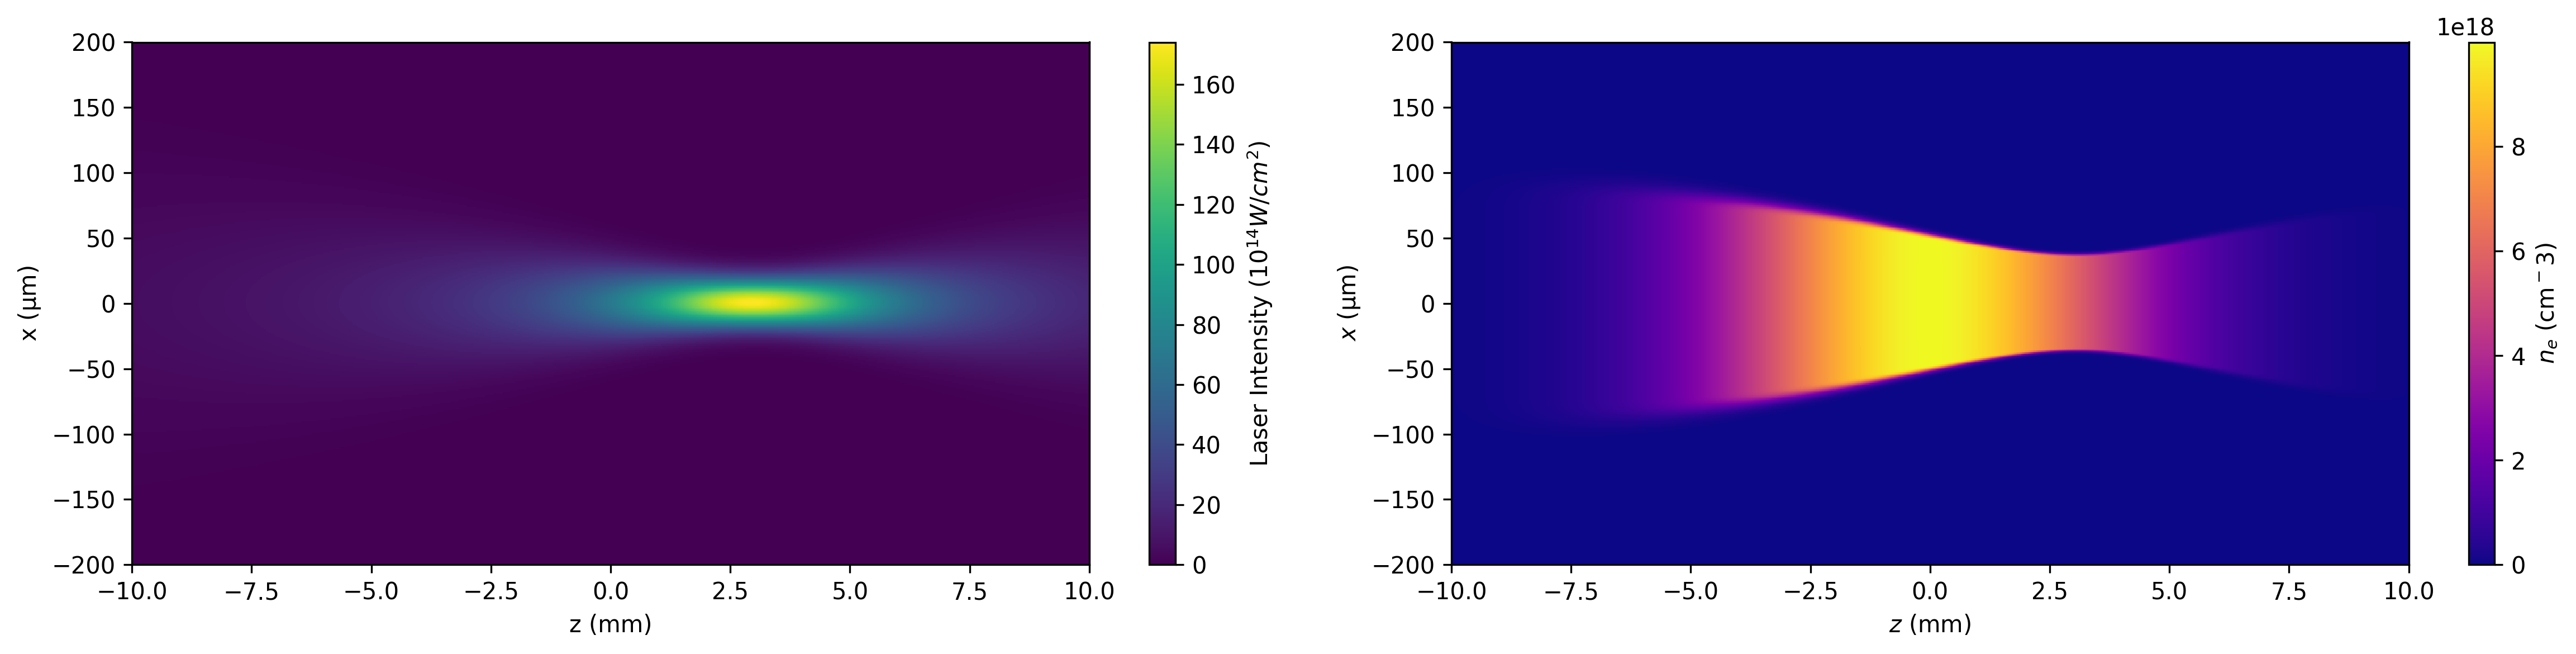

Initial pulse energy 12.01mJ
Final pulse energy 5.69mJ


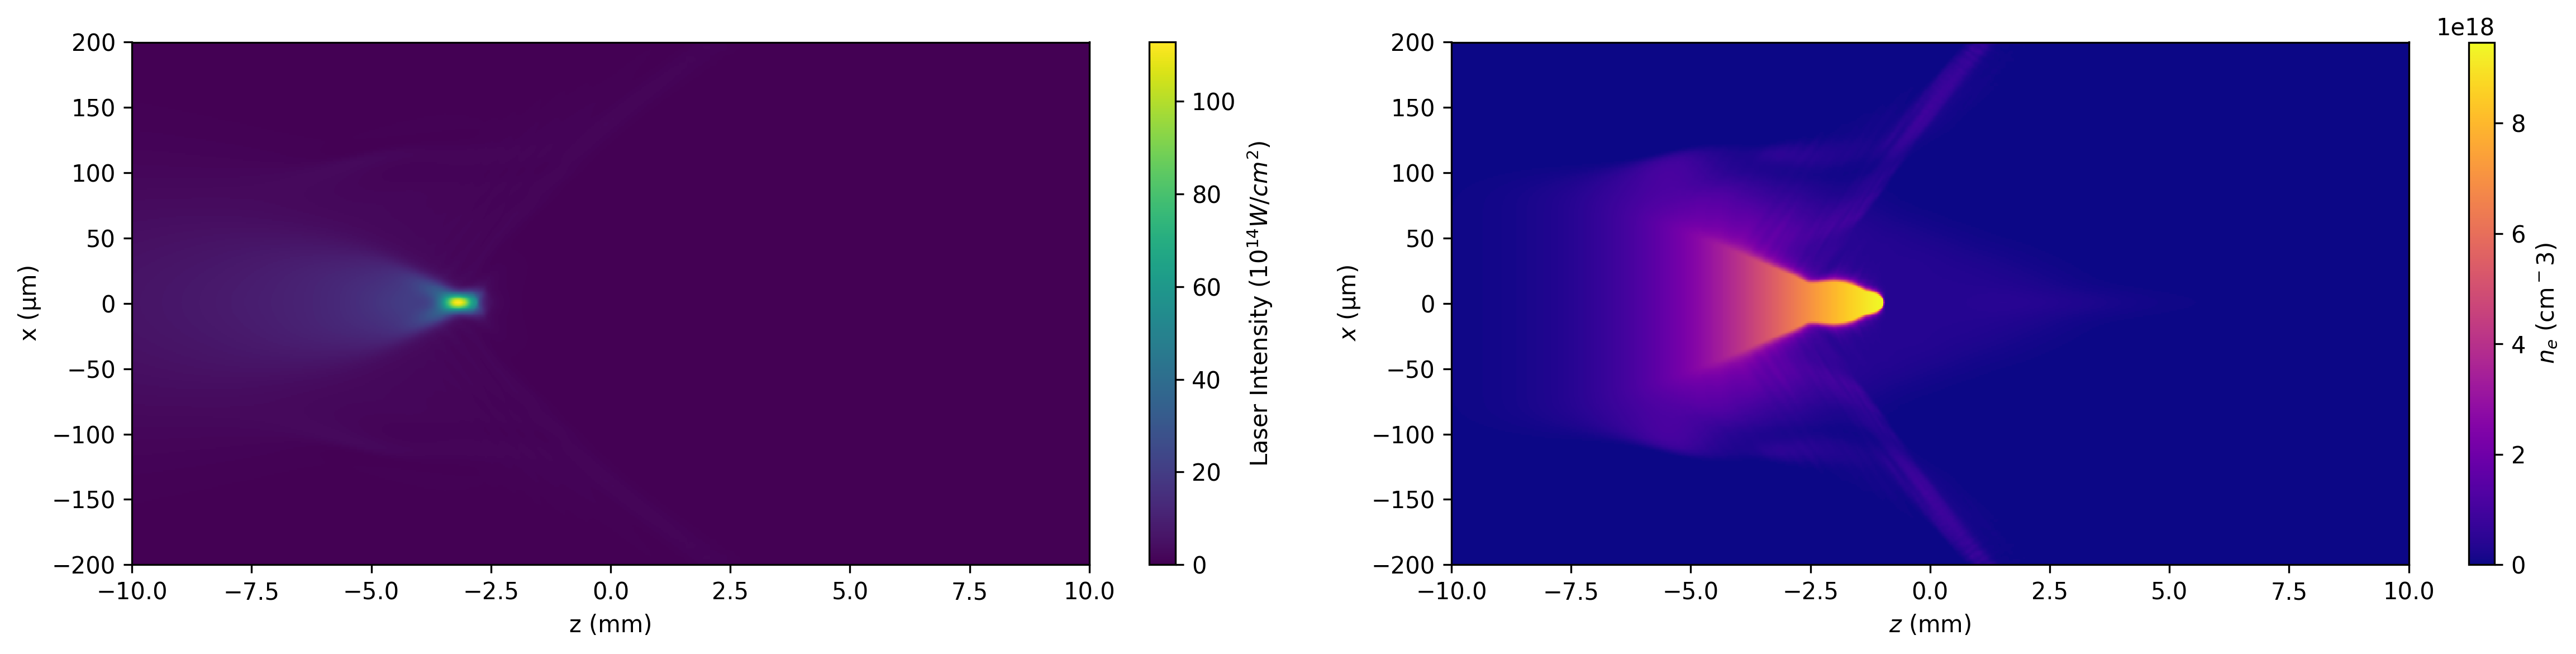

In [4]:
energy = 12e-3
w0 = 25
Nx = 2**9
X = 600
Nz = 800
Z = 20e3
z0 = -3e3
n0 = 1e19
atom = ionization.H2
temp = 100
pulse = ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z)

In [23]:
name = 'Energy=12.00mJ_w0=25.0um_z0=-3.00mm_n0=1.00E+19_T=0eV_Pulse'
pulseParams = {
    'Nt' : 2**6,
    'Nx' : 2**10,
    'Ny' : 2**10,
    'X' : 10e3,
    'Y' : 10e3,
    'T' : 90,
    'lam' : 0.8,
    'path' : path,
    'load' : True,
    'threads' : 4,
    'cyl' : True,
    'tau' : 30,
    'name' : name,
    'E0' : 1,
    'waist' : 1,
    'z0' : 1,
}
pulse = laserpulse.Pulse(pulseParams)

In [24]:
design.pulse_evolution(pulse, '1e19_12mJ_NoHeating', [-200, 200], False)

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed
Frame 210 completed
Frame 240 completed
Frame 270 completed
Frame 300 completed
Frame 330 completed
Frame 360 completed
Frame 390 completed
Frame 420 completed
Frame 450 completed
Frame 480 completed
Frame 510 completed
Frame 540 completed
Frame 570 completed
Frame 600 completed
Frame 630 completed
Frame 660 completed
Frame 690 completed
Frame 720 completed
Frame 750 completed
Frame 780 completed


In [25]:
print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))

Final pulse energy 13.63mJ


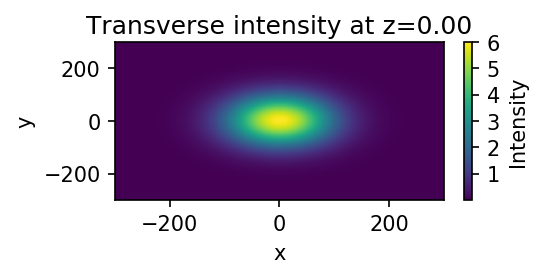

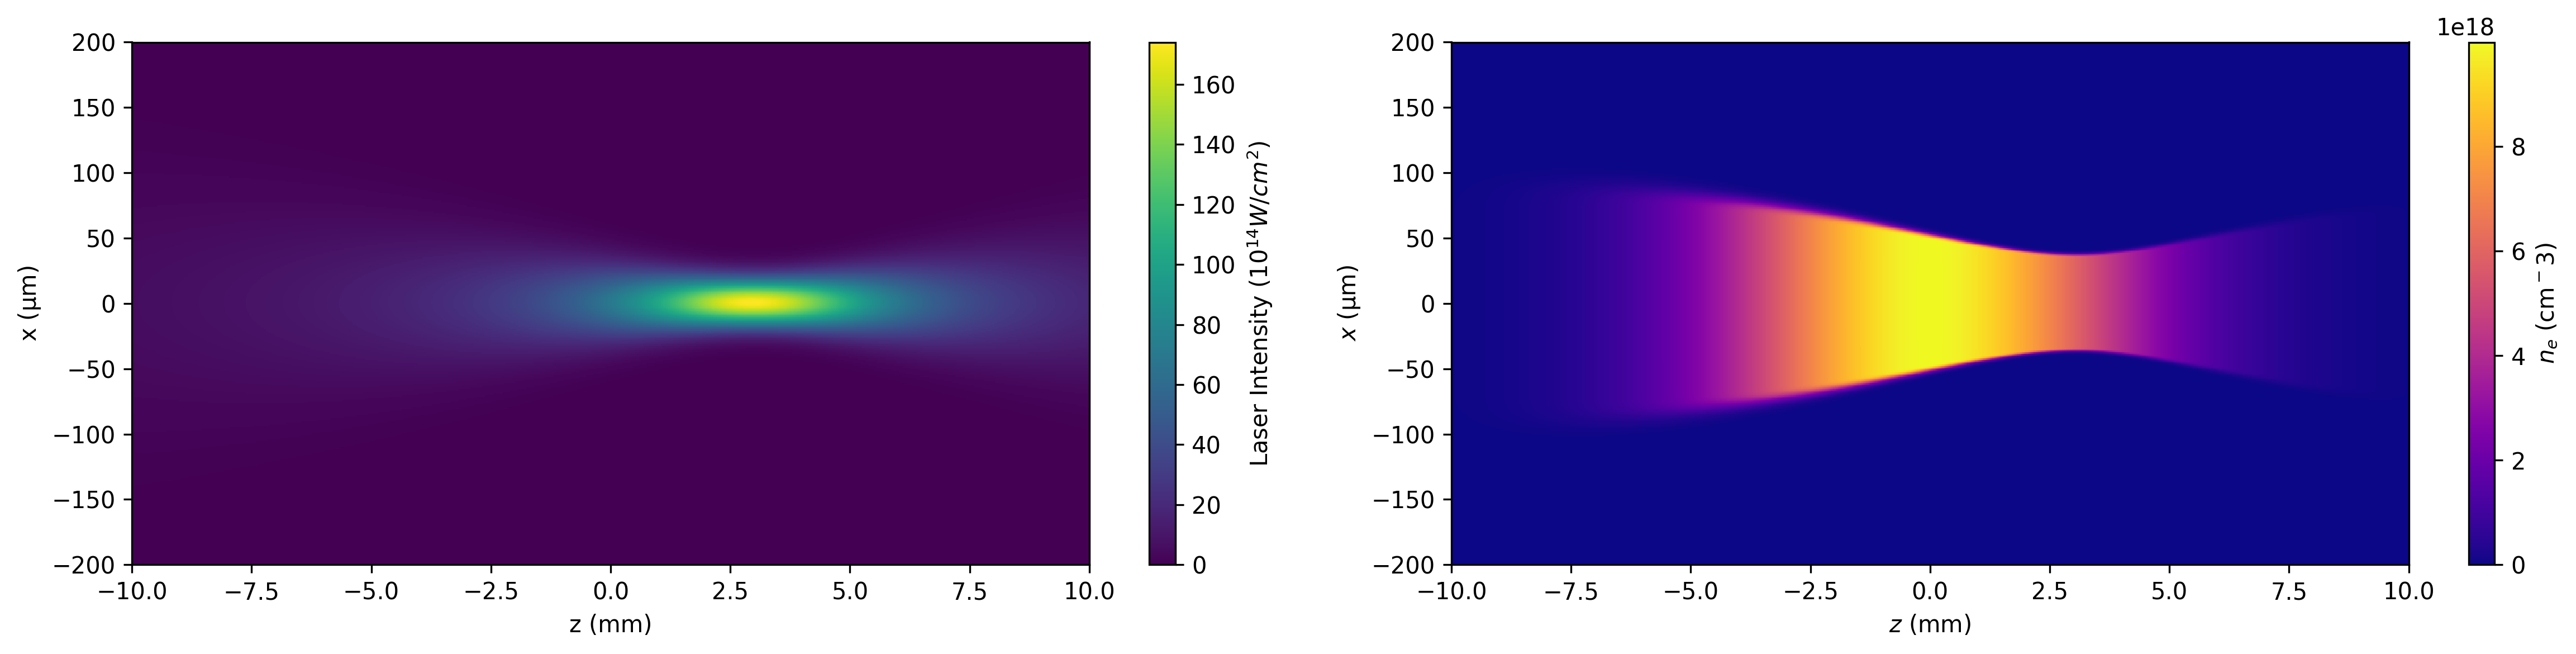

Initial pulse energy 12.01mJ
Final pulse energy 9.95mJ


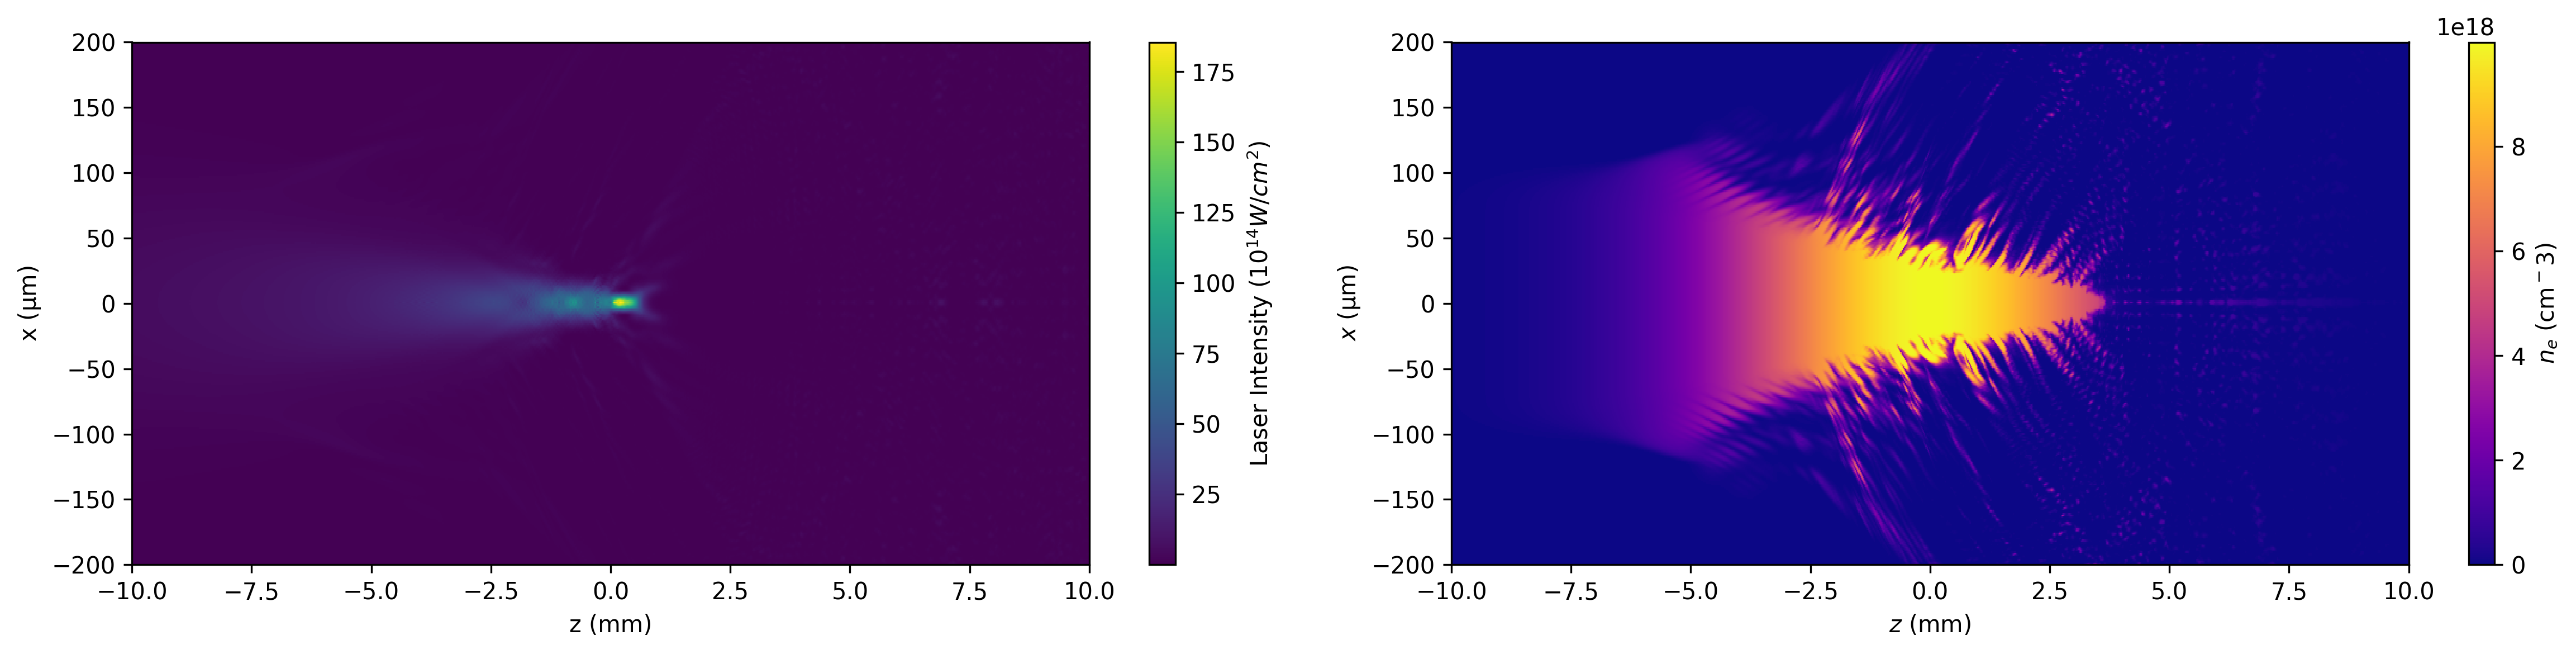

In [6]:
energy = 12e-3
w0 = 25
Nx = 2**9
X = 600
Nz = 800
Z = 20e3
z0 = -3e3
n0 = 1e19
atom = ionization.H2
temp = 0
pulse = ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z)

In [ ]:
design.pulse_evolution(pulse, '1e19_12mJ_NoHeating', [-200, 200], False)

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed
Frame 210 completed
Frame 240 completed
Frame 270 completed
Frame 300 completed
Frame 330 completed
Frame 360 completed
Frame 390 completed
Frame 420 completed
Frame 450 completed
Frame 480 completed
Frame 510 completed
Frame 540 completed
Frame 570 completed
Frame 600 completed
Frame 630 completed
Frame 660 completed
Frame 690 completed
Frame 720 completed
Frame 750 completed
Frame 780 completed


Initial pulse energy 25.01mJ
Final pulse energy 7.38mJ


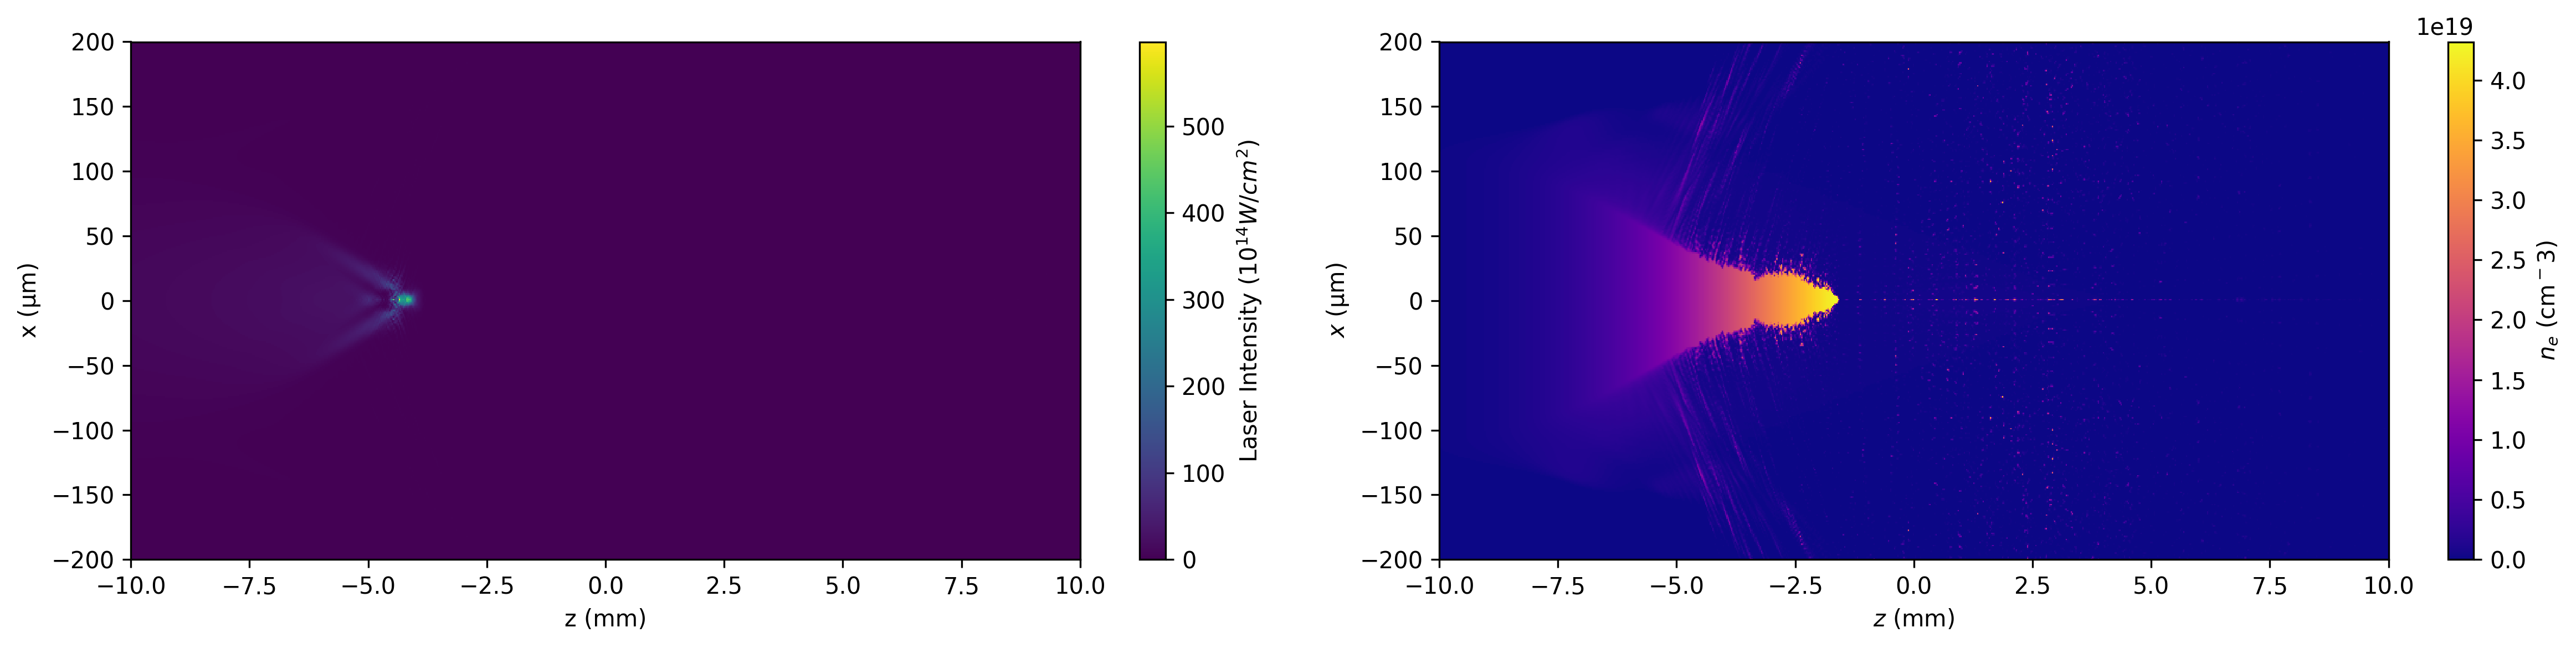

Initial pulse energy 50.03mJ
Final pulse energy 10.78mJ


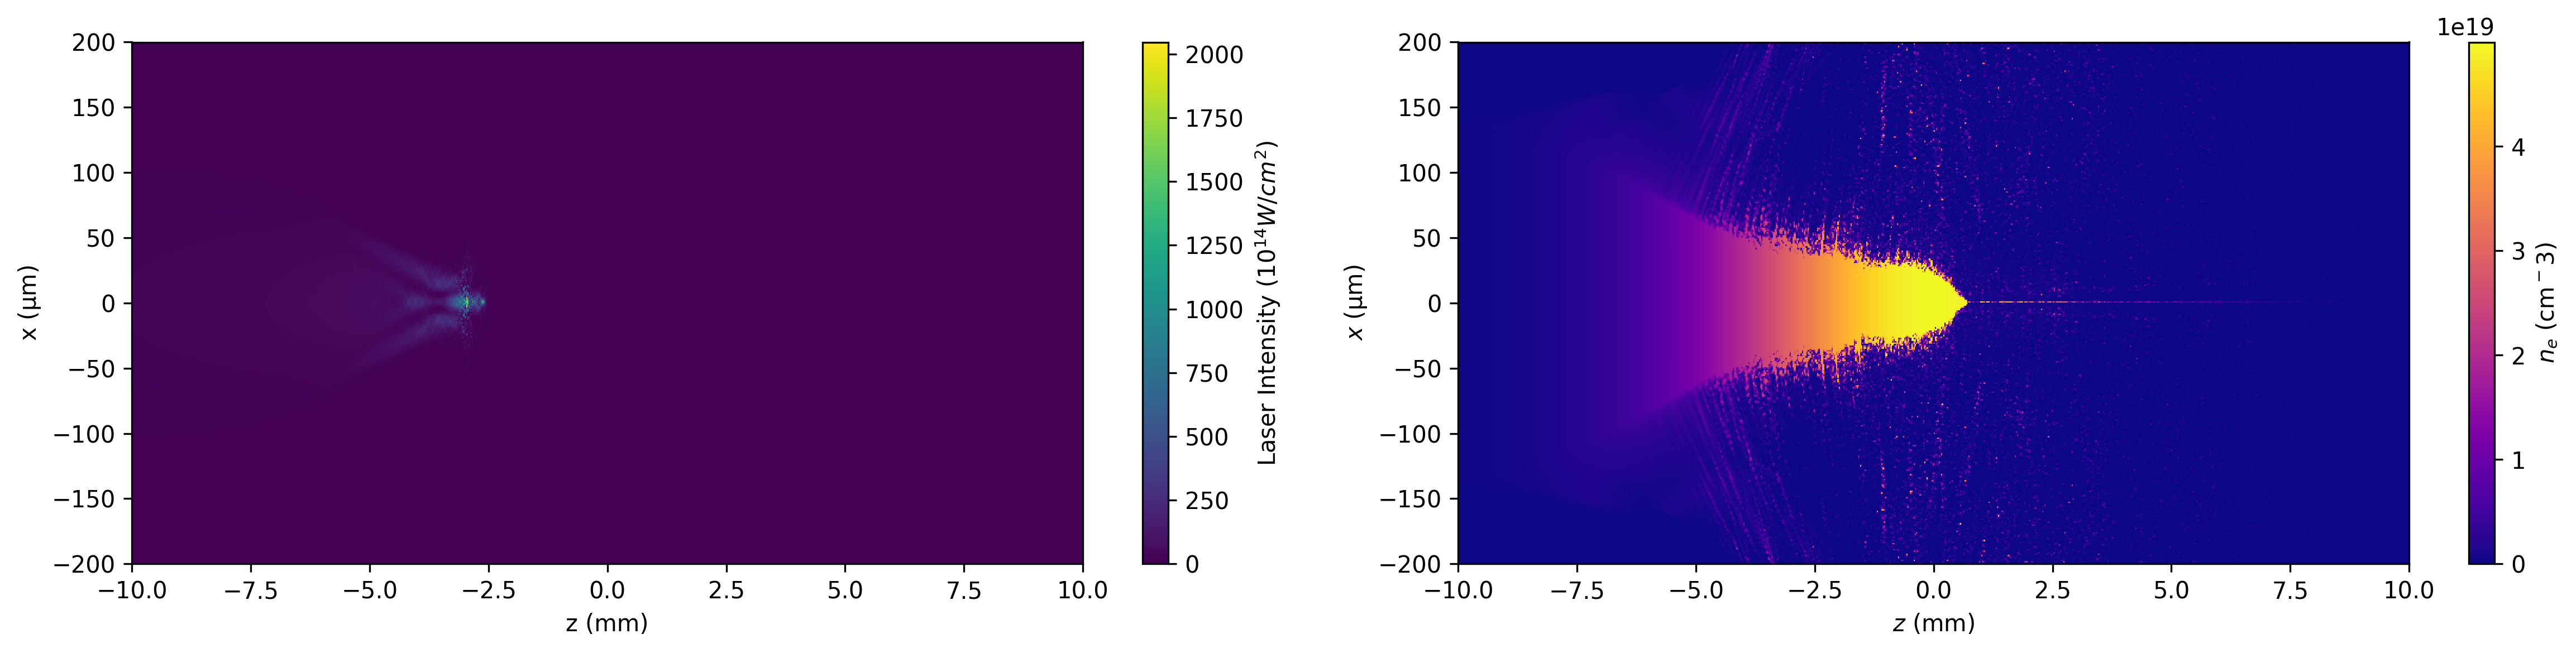

Initial pulse energy 75.04mJ
Final pulse energy 12.75mJ


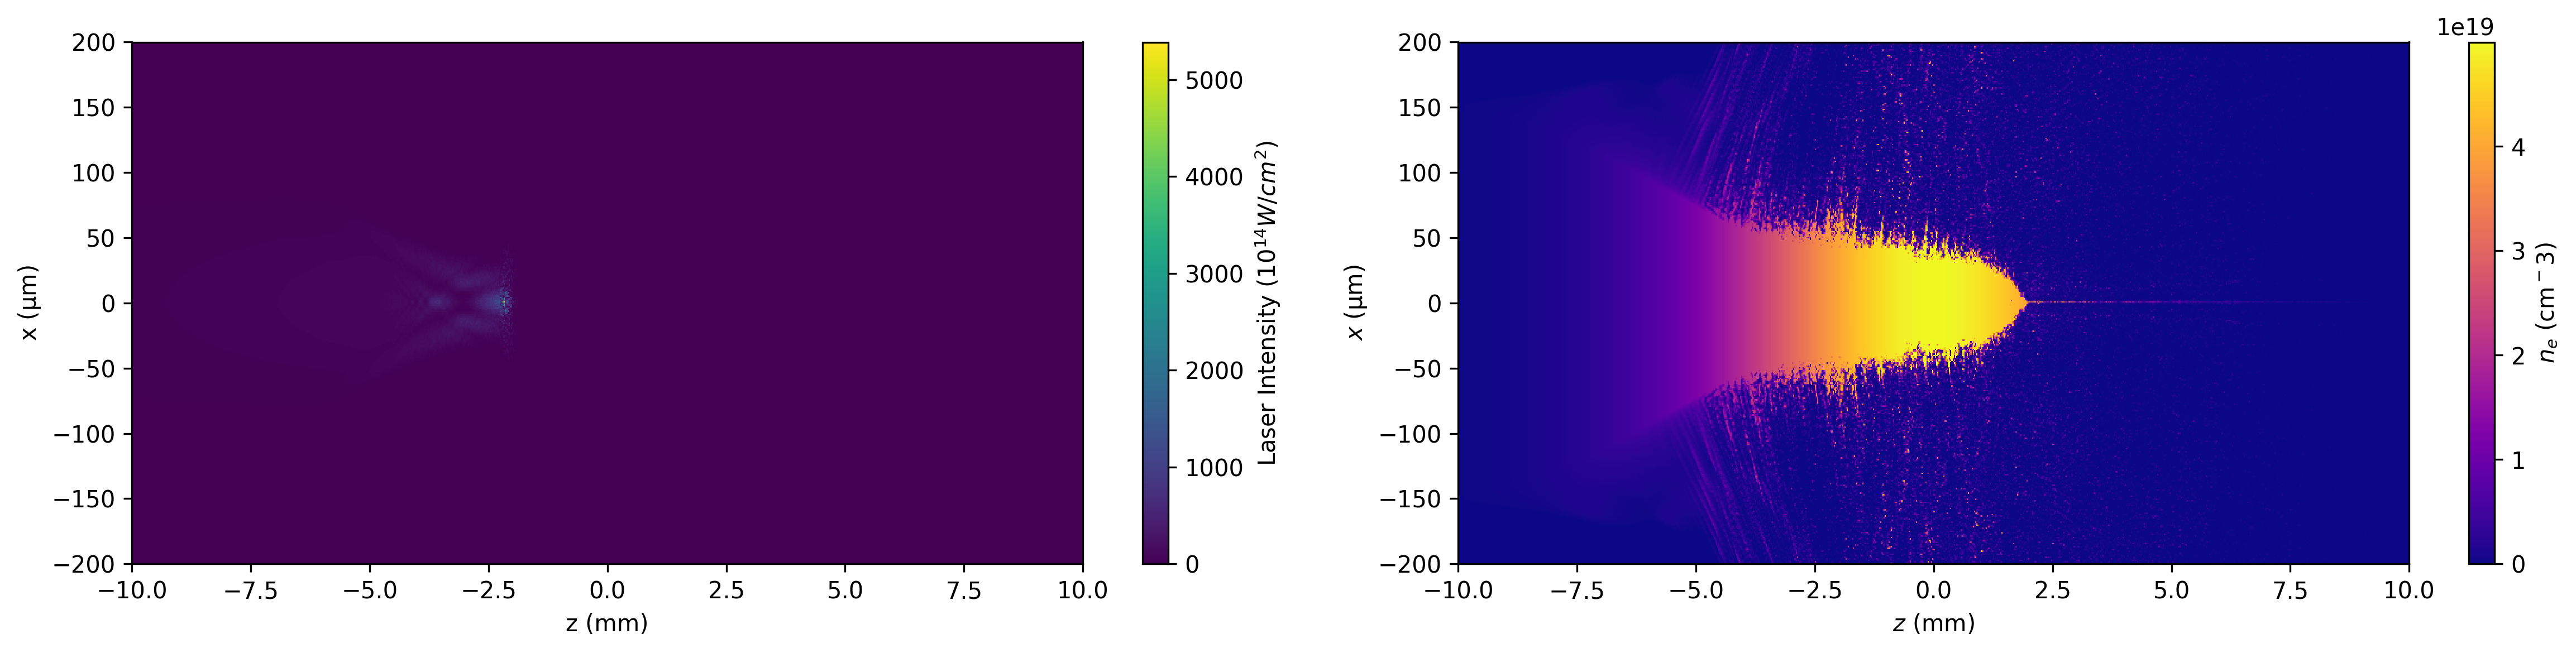

Initial pulse energy 100.05mJ
Final pulse energy 14.50mJ


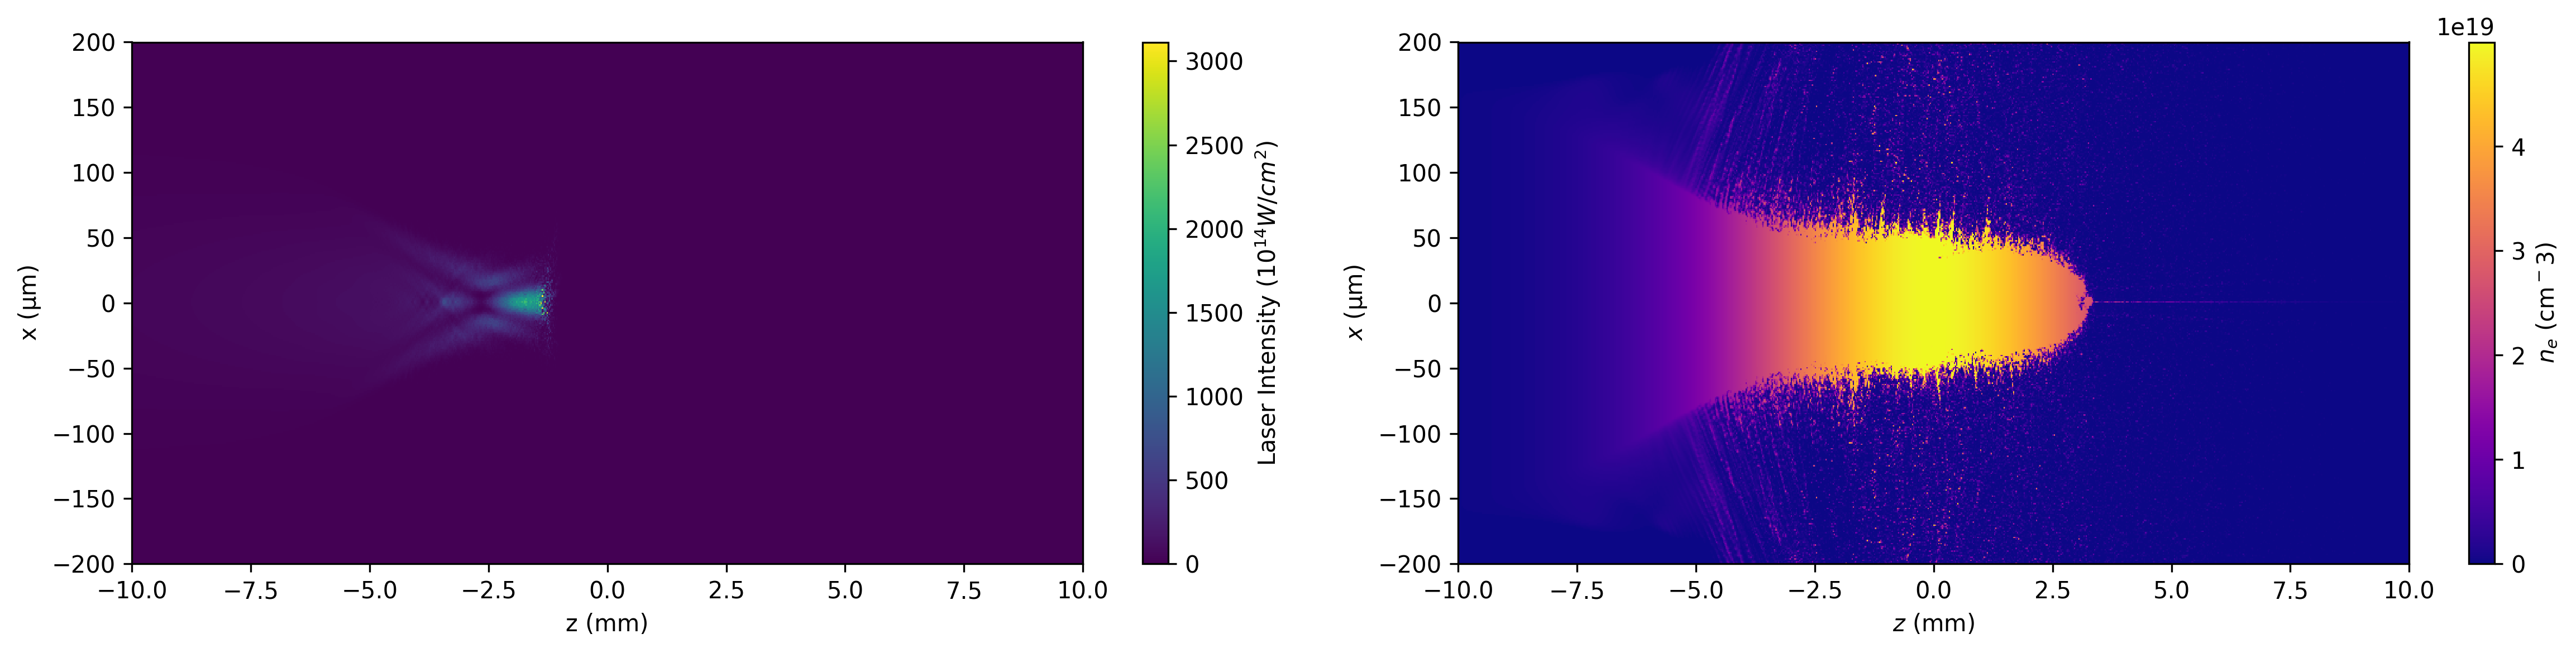

Initial pulse energy 125.07mJ


In [ ]:
energy = np.array([25e-3, 50e-3, 75e-3, 100e-3, 125e-3, 150e-3])
w0 = 25
Nx = 2**8
X = 600
Nz = 400
Z = 20e3
z0 = -3e3
n0 = 5e19
atom = ionization.H2
temp = 100
for i in range(len(energy)):
    pulse = ionize_jet(energy[i], w0, z0, n0, atom, temp, Nx, X, Nz, Z, False)

In [ ]:
energy = np.array([25e-3, 50e-3, 75e-3, 100e-3, 125e-3])
w0 = 25
Nx = 2**8
X = 600
Nz = 400
Z = 20e3
z0 = -3e3
n0 = 1e20
atom = ionization.H2
temp = 100
for i in range(len(energy)):
    pulse = ionize_jet(energy[i], w0, z0, n0, atom, temp, Nx, X, Nz, Z, False)

Initial pulse energy 150.08mJ
Final pulse energy 13.15mJ


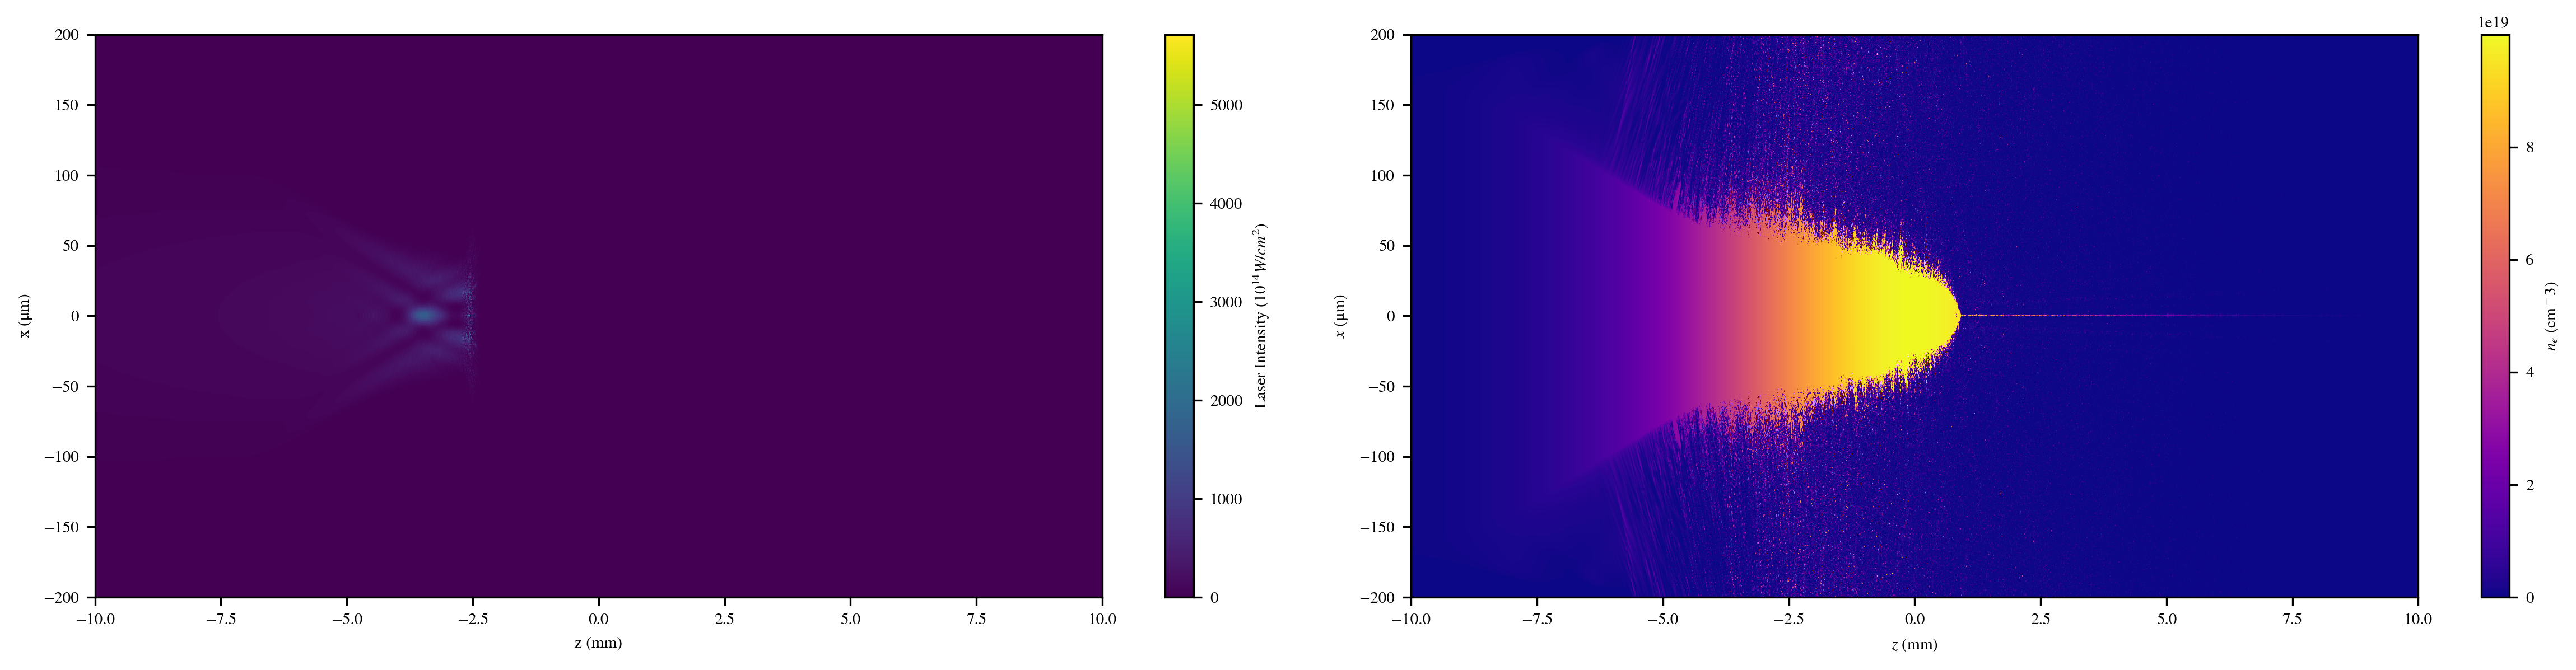

In [26]:
energy = 150e-3
w0 = 25
Nx = 2**10
X = 600
Nz = 3200
Z = 20e3
z0 = -3e3
n0 = 1e20
atom = ionization.H2
temp = 100
pulse = ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z, False)

In [14]:
design.pulse_evolution(pulse, '1e20_150mJ', [-150, 150], False)

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed
Frame 210 completed
Frame 240 completed
Frame 270 completed
Frame 300 completed
Frame 330 completed
Frame 360 completed
Frame 390 completed
Frame 420 completed
Frame 450 completed
Frame 480 completed
Frame 510 completed
Frame 540 completed
Frame 570 completed
Frame 600 completed
Frame 630 completed
Frame 660 completed
Frame 690 completed
Frame 720 completed
Frame 750 completed
Frame 780 completed
Frame 810 completed
Frame 840 completed
Frame 870 completed
Frame 900 completed
Frame 930 completed
Frame 960 completed
Frame 990 completed
Frame 1020 completed
Frame 1050 completed
Frame 1080 completed
Frame 1110 completed
Frame 1140 completed
Frame 1170 completed
Frame 1200 completed
Frame 1230 completed
Frame 1260 completed
Frame 1290 completed
Frame 1320 completed
Frame 1350 completed
Frame 1380 completed
Frame 1410 completed
Frame 1440 completed
Frame 1470 completed
Frame 1

In [ ]:
energy = 150e-3
w0 = 25
Nx = 2**10
X = 600
Nz = 1600
Z = 20e3
z0 = -3e3
n0 = 1e20
atom = ionization.H2
temp = 0
pulse = ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z, False)

In [ ]:
design.pulse_evolution(pulse, '1e20_150mJ_NoHeating', [-150, 150], False)

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed
Frame 210 completed
Frame 240 completed
Frame 270 completed
Frame 300 completed
Frame 330 completed
Frame 360 completed
Frame 390 completed
Frame 420 completed
Frame 450 completed
Frame 480 completed
Frame 510 completed
Frame 540 completed
Frame 570 completed
Frame 600 completed
Frame 630 completed
Frame 660 completed
Frame 690 completed
Frame 720 completed
Frame 750 completed
Frame 780 completed
Frame 810 completed
Frame 840 completed
Frame 870 completed
Frame 900 completed
Frame 930 completed
Frame 960 completed
Frame 990 completed
Frame 1020 completed
Frame 1050 completed
Frame 1080 completed
Frame 1110 completed
Frame 1140 completed
Frame 1170 completed
Frame 1200 completed
Frame 1230 completed
Frame 1260 completed
Frame 1290 completed
Frame 1320 completed
Frame 1350 completed
Frame 1380 completed
Frame 1410 completed
Frame 1440 completed
Frame 1470 completed
Frame 1